In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.stats as stats 
import numpy as np
import os 
import sklearn

In [2]:
# Modelling Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [3]:
# cols to check and drop if missing data 
    # string, either - PWS, FW, t25fw, or edss 

def drop_cols_missing_data(df, cols_to_check):
    # drop row if all PWS mat vars are nan
    if cols_to_check == 'pws': 
        subset_columns = ['PWS_stridetimesecmean',
                          'PWS_stridetimeseccv',
                          'PWS_cadencestepsminmean',
                          'PWS_totaldsupportmean',
                          'PWS_singlesupportmean', 
                          'PWS_totaldsupportratiolr',
                          'PWS_singlesupportratiolr',
                          'PWS_stridewidthcmmean', 
                          'PWS_stridewidthcmsd']

    # drop row if all FW mat vars are nan 
    elif cols_to_check == 'fw':
        subset_columns = ['FW_stridetimesecmean',
                          'FW_stridetimeseccv',
                          'FW_cadencestepsminmean',
                          'FW_totaldsupportmean',
                          'FW_singlesupportmean', 
                          'FW_totaldsupportratiolr',
                          'FW_singlesupportratiolr',
                          'FW_stridewidthcmmean', 
                          'FW_stridewidthcmsd']
        
    # drop row if edss is nan
    elif cols_to_check == 'edss':
        subset_columns = ['bingoEHR_EDSS_measure_value']

    # drop row is tw5fw is nan 
    elif cols_to_check == 't25fw':
        subset_columns = ['msfcEHR_T25FW SPEED AVG']

    df_missing_rows_dropped = df.dropna(axis = 0, 
                                        how = 'all',
                                        subset = subset_columns)

    return df_missing_rows_dropped

In [4]:
# df input should be merged df - both video and bw data 

def print_video_counts(df):
    # number of zeno videos and participants included 
    print('total videos - df length: ' + 
          str(len(df))) 

    print('unique demographic_diagnosis in df: ' + 
         str(pd.unique(df['demographic_diagnosis'])))
    
    print('num videos with demographic_diagnosis == HC: ' + 
         str(len(df[df['demographic_diagnosis'] == 'HC']))) 

    print('num videos demographic_diagnosis == MS: ' + 
         str(len(df[df['demographic_diagnosis'] == 'MS']))) 

    print('------')

    print('unique id_video (participants) in df: ' + 
          str(len(pd.unique(df['id_video'])))) 

    print('num participants with demographic_diagnosis == HC: ' + 
         str(len(pd.unique(df['id_video'][df['demographic_diagnosis'] == 'HC'])))) 
    
    print('num participants demographic_diagnosis == MS: ' + 
         str(len(pd.unique(df['id_video'][df['demographic_diagnosis'] == 'MS']))))

    print('------') 
    
    print('number of participants with multiple videos in dataset: ' + 
         str(df['id_video'][df['id_video'].duplicated()].nunique()))

    print('number of participants with one video: ' + 
          str((df['id_video'].value_counts() == 1).sum()))

# Load data 

In [5]:
# output folder 
output_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_bw_zeno_home_analysis\002\00_classification'

In [6]:
# load merged pws data 
bw_zv_pws_df = pd.read_csv(r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_bw_zeno_home_analysis\002\zv_bw_merged_gait_vertical_PWS_1.csv',
                          index_col = 0)

# load merged fw data 
bw_zv_fw_df = pd.read_csv(r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_bw_zeno_home_analysis\002\zv_bw_merged_gait_vertical_FW_1.csv',
                          index_col = 0)
                    

In [7]:
# add columns for ordinal EDSS severity and t25fw 
bw_zv_pws_df['edss_severity_cat'] = pd.Categorical(bw_zv_pws_df['edss_severity_cat'], categories=["mild", "moderate", "severe"], ordered=True)
bw_zv_pws_df['t25fw_group_cat'] = pd.Categorical(bw_zv_pws_df['t25fw_group_cat'], categories=["under_6", "6_to_8", "over_8"], ordered=True)

bw_zv_fw_df['edss_severity_cat'] = pd.Categorical(bw_zv_fw_df['edss_severity_cat'], categories=["mild", "moderate", "severe"], ordered=True)
bw_zv_fw_df['t25fw_group_cat'] = pd.Categorical(bw_zv_fw_df['t25fw_group_cat'], categories=["under_6", "6_to_8", "over_8"], ordered=True)

In [8]:
# zeno preferred walk - participants with pws videos and t25fw 
bw_zv_pws_t25fw_df = drop_cols_missing_data(bw_zv_pws_df, cols_to_check = 't25fw')
print_video_counts(bw_zv_pws_t25fw_df) 

total videos - df length: 148
unique demographic_diagnosis in df: ['MS']
num videos with demographic_diagnosis == HC: 0
num videos demographic_diagnosis == MS: 148
------
unique id_video (participants) in df: 126
num participants with demographic_diagnosis == HC: 0
num participants demographic_diagnosis == MS: 126
------
number of participants with multiple videos in dataset: 22
number of participants with one video: 104


In [9]:
# zeno preferred walk - participants with pws videos and edss 
bw_zv_pws_edss_df = drop_cols_missing_data(bw_zv_pws_df, cols_to_check = 'edss')
print_video_counts(bw_zv_pws_edss_df) 

total videos - df length: 200
unique demographic_diagnosis in df: ['MS']
num videos with demographic_diagnosis == HC: 0
num videos demographic_diagnosis == MS: 200
------
unique id_video (participants) in df: 139
num participants with demographic_diagnosis == HC: 0
num participants demographic_diagnosis == MS: 139
------
number of participants with multiple videos in dataset: 59
number of participants with one video: 80


In [10]:
# zeno fast walk - participants with fw videos and t25fw 
bw_zv_fw_t25fw_df = drop_cols_missing_data(bw_zv_fw_df, cols_to_check = 't25fw')
print_video_counts(bw_zv_fw_t25fw_df) 

total videos - df length: 146
unique demographic_diagnosis in df: ['MS']
num videos with demographic_diagnosis == HC: 0
num videos demographic_diagnosis == MS: 146
------
unique id_video (participants) in df: 123
num participants with demographic_diagnosis == HC: 0
num participants demographic_diagnosis == MS: 123
------
number of participants with multiple videos in dataset: 22
number of participants with one video: 101


In [11]:
# zeno fast walk - participants with fw videos and edss 
bw_zv_fw_edss_df = drop_cols_missing_data(bw_zv_fw_df, cols_to_check = 'edss')
print_video_counts(bw_zv_fw_edss_df) 

total videos - df length: 192
unique demographic_diagnosis in df: ['MS']
num videos with demographic_diagnosis == HC: 0
num videos demographic_diagnosis == MS: 192
------
unique id_video (participants) in df: 138
num participants with demographic_diagnosis == HC: 0
num participants demographic_diagnosis == MS: 138
------
number of participants with multiple videos in dataset: 53
number of participants with one video: 85


# TO DO: HOW TO SAVE RESULTS?

# Random forest classification 
Better correlation, but no fast walk for home 
- model 1: fast walk video metrics: stride time, cadence, stride width -> EDSS 
- model 2:  fast walk video metrics: stride time, cadence, stride width -> T25FW

- model 3: AGE + fast walk video metrics: stride time, cadence, stride width -> EDSS
- model 4: AGE + fast walk video metrics: stride time, cadence, stride width -> T25FW

Next - preferred walking speed vids and fast walking vids together?? Fast only? Other vid metrics? Add gender (or other metrics we might know remotely)? 

In [12]:
# Random Forest Parameters 
rf = RandomForestClassifier()
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [13]:
# set parameter grid for random forest, 5x cross-validation 

# start with random samples --> narrow parameter grid for each model around best param values 
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,50)}


# 'n_estimators': up to 500, max depth = 50 

# script to use later with randomized search 
#param_grid = {'n_estimators' : list(range(100, 150)), 
           #   'max_depth': list(range(5,51))}

#grid_search1 = GridSearchCV(rf, param_grid, cv=5)
#grid_search1.fit(X1_train, y1_train)

## Model 1: predictors - fast walk video metrics; outcome: EDSS 

In [14]:
# drop rows with missing data 
model1_edss_df = bw_zv_fw_edss_df[['stride_time_mean_sec_pose_zv', 'mean_cadence_step_per_min_pose_zv', 'stride_width_mean_cm_pose_zv',
                             'edss_severity_cat']]
print(len(model1_edss_df))

model1_edss_df_2 = model1_edss_df.dropna(inplace=False)

print(len(model1_edss_df_2))

192
183


In [15]:
# predictors (X1) 
X1 = model1_edss_df_2[['stride_time_mean_sec_pose_zv', 'mean_cadence_step_per_min_pose_zv', 'stride_width_mean_cm_pose_zv']]
print(X1.dtypes)

# outcome = EDSS severity 
y1 = model1_edss_df_2['edss_severity_cat']
print(y1.dtypes)

# split into training and test sets: 80% train, 20% test 
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2)
# train 
print(X1_train.index)
print(len(X1_train))
print(y1_train.index)
print(len(y1_train))

# test 
print(X1_test.index)
print(len(X1_test))
print(y1_test.index)
print(len(y1_test))

stride_time_mean_sec_pose_zv         float64
mean_cadence_step_per_min_pose_zv    float64
stride_width_mean_cm_pose_zv         float64
dtype: object
category
Index([136, 113, 221,  87, 142,  39, 140, 207,  99, 112,
       ...
       101, 132,  27,  82,  67, 137,  50,   5,  88, 122],
      dtype='int64', length=146)
146
Index([136, 113, 221,  87, 142,  39, 140, 207,  99, 112,
       ...
       101, 132,  27,  82,  67, 137,  50,   5,  88, 122],
      dtype='int64', length=146)
146
Index([104,  73, 110,  18, 174, 111, 165,   7, 127,  76, 208,  54, 186,  31,
        37,  22,  78,  48,  11, 202, 185,  98, 220, 155, 154, 195,  95,  65,
        25,  34,  47,  66,   9, 177,  38,  96,  28],
      dtype='int64')
37
Index([104,  73, 110,  18, 174, 111, 165,   7, 127,  76, 208,  54, 186,  31,
        37,  22,  78,  48,  11, 202, 185,  98, 220, 155, 154, 195,  95,  65,
        25,  34,  47,  66,   9, 177,  38,  96,  28],
      dtype='int64')
37


In [16]:
# tune hyperparameters with randomized search 
rand_search1 = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=50, 
                                 cv=5)

rand_search1.fit(X1_train, y1_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001451DAAEE00>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001451DAAF370>})

In [17]:
# Print best parameters from grid search 
best_rf1 = rand_search1.best_estimator_
print('Best hyperparameters:',  rand_search1.best_params_)

Best hyperparameters: {'max_depth': 2, 'n_estimators': 405}


In [18]:
# generate predictions from the best model 
y1_pred = best_rf1.predict(X1_test)

In [19]:
# evaluate accuracy, precision, and recall of pred vs true test y vals 
# see documentation for differences in values, think weighted makes most sense 
accuracy = accuracy_score(y1_test, y1_pred)

precision_micro = precision_score(y1_test, y1_pred, average = 'micro')
precision_macro = precision_score(y1_test, y1_pred, average = 'macro')
precision_weighted = precision_score(y1_test, y1_pred, average = 'weighted')

recall_micro = recall_score(y1_test, y1_pred, average = 'micro')
recall_macro = recall_score(y1_test, y1_pred, average = 'macro')
recall_weighted = recall_score(y1_test, y1_pred, average = 'weighted')

print("Accuracy:", accuracy)
print("Precision Micro:", precision_micro)
print("Precision Macro:", precision_macro)
print("Precision Weighted:", precision_weighted)
print("Recall Micro:", recall_micro)
print("Recall Macro:", recall_macro)
print("Recall Weighted:", recall_weighted)

Accuracy: 0.5405405405405406
Precision Micro: 0.5405405405405406
Precision Macro: 0.6
Precision Weighted: 0.5567567567567568
Recall Micro: 0.5405405405405406
Recall Macro: 0.5327380952380952
Recall Weighted: 0.5405405405405406


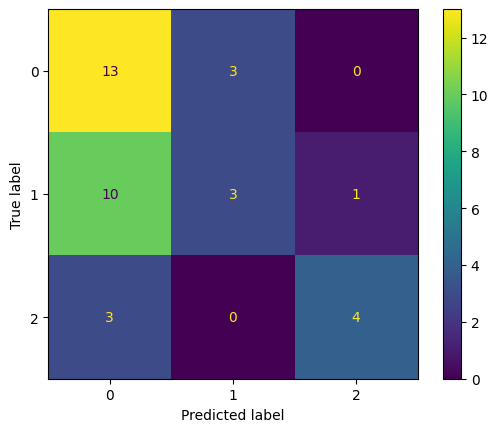

In [20]:
# create confusion matrix 
cm1 = confusion_matrix(y1_test, y1_pred)
ConfusionMatrixDisplay(confusion_matrix=cm1).plot();

<Axes: >

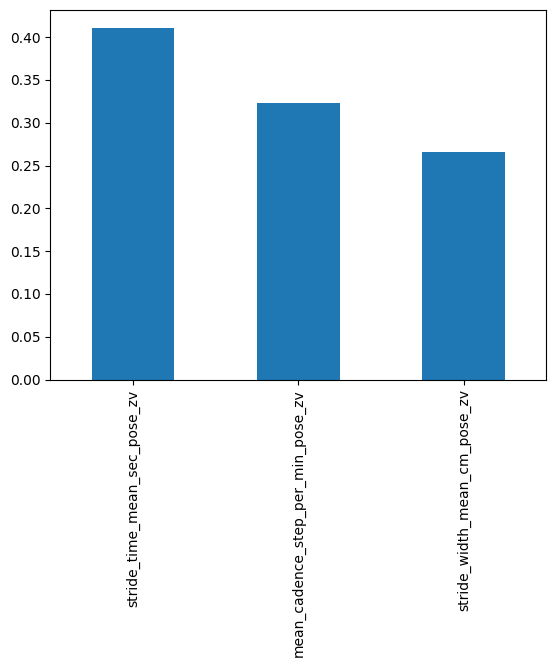

In [21]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances1 = pd.Series(best_rf1.feature_importances_, 
                                index=X1_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances1.plot.bar()

## Model 2: predictors - fast walk video metrics; outcome: T25FW categories  

In [22]:
# drop rows with missing data 
model2_t25fw_df = bw_zv_fw_t25fw_df[['stride_time_mean_sec_pose_zv', 'mean_cadence_step_per_min_pose_zv', 'stride_width_mean_cm_pose_zv',
                                     't25fw_group_cat']]
print(len(model2_t25fw_df))

model2_t25fw_df_2 = model2_t25fw_df.dropna(inplace=False)

print(len(model2_t25fw_df_2))

146
141


In [23]:
# predictors (X2) 
X2 = model2_t25fw_df_2[['stride_time_mean_sec_pose_zv', 'mean_cadence_step_per_min_pose_zv', 'stride_width_mean_cm_pose_zv']]
print(X2.dtypes)

# outcome = EDSS severity 
y2 = model2_t25fw_df_2['t25fw_group_cat']
print(y2.dtypes)

# split into training and test sets: 80% train, 20% test 
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2)
# train 
print(X2_train.index)
print(len(X2_train))
print(y2_train.index)
print(len(y2_train))

# test 
print(X2_test.index)
print(len(X2_test))
print(y2_test.index)
print(len(y2_test))

stride_time_mean_sec_pose_zv         float64
mean_cadence_step_per_min_pose_zv    float64
stride_width_mean_cm_pose_zv         float64
dtype: object
category
Index([ 49, 142,  54, 124,  14,   5,  78,  81,  92, 155,
       ...
       112,  11,  29,  40, 136,  55, 157, 211, 220, 156],
      dtype='int64', length=112)
112
Index([ 49, 142,  54, 124,  14,   5,  78,  81,  92, 155,
       ...
       112,  11,  29,  40, 136,  55, 157, 211, 220, 156],
      dtype='int64', length=112)
112
Index([221,   7,  94, 113, 204, 182, 108,   8, 101, 169, 146, 110, 130,  64,
        86,  18,  76, 129, 178, 104,  98,  19, 214,  23,  45, 170, 143, 193,
       144],
      dtype='int64')
29
Index([221,   7,  94, 113, 204, 182, 108,   8, 101, 169, 146, 110, 130,  64,
        86,  18,  76, 129, 178, 104,  98,  19, 214,  23,  45, 170, 143, 193,
       144],
      dtype='int64')
29


In [24]:
# tune hyperparameters with randomized search 
rand_search2 = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=50, 
                                 cv=5)

rand_search2.fit(X2_train, y2_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001451DAAEE00>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001451DAAF370>})

In [25]:
# Print best parameters from grid search 
best_rf2 = rand_search2.best_estimator_
print('Best hyperparameters:',  rand_search2.best_params_)

Best hyperparameters: {'max_depth': 3, 'n_estimators': 253}


In [26]:
# generate predictions from the best model 
y2_pred = best_rf2.predict(X2_test)

In [27]:
# evaluate accuracy, precision, and recall of pred vs true test y vals 
# see documentation for differences in values, think weighted makes most sense 
accuracy = accuracy_score(y2_test, y2_pred)

precision_micro = precision_score(y2_test, y2_pred, average = 'micro')
precision_macro = precision_score(y2_test, y2_pred, average = 'macro')
precision_weighted = precision_score(y2_test, y2_pred, average = 'weighted')

recall_micro = recall_score(y2_test, y2_pred, average = 'micro')
recall_macro = recall_score(y2_test, y2_pred, average = 'macro')
recall_weighted = recall_score(y2_test, y2_pred, average = 'weighted')

print("Accuracy:", accuracy)
print("Precision Micro:", precision_micro)
print("Precision Macro:", precision_macro)
print("Precision Weighted:", precision_weighted)
print("Recall Micro:", recall_micro)
print("Recall Macro:", recall_macro)
print("Recall Weighted:", recall_weighted)

Accuracy: 0.8275862068965517
Precision Micro: 0.8275862068965517
Precision Macro: 0.5042735042735043
Precision Weighted: 0.6878868258178603
Recall Micro: 0.8275862068965517
Recall Macro: 0.6666666666666666
Recall Weighted: 0.8275862068965517


C:\Users\mmccu\venv_home_video_analysis_2\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mmccu\venv_home_video_analysis_2\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


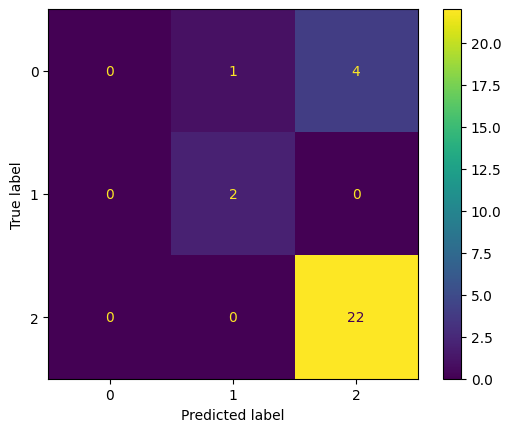

In [28]:
# create confusion matrix 
cm2 = confusion_matrix(y2_test, y2_pred)
ConfusionMatrixDisplay(confusion_matrix=cm2).plot();

<Axes: >

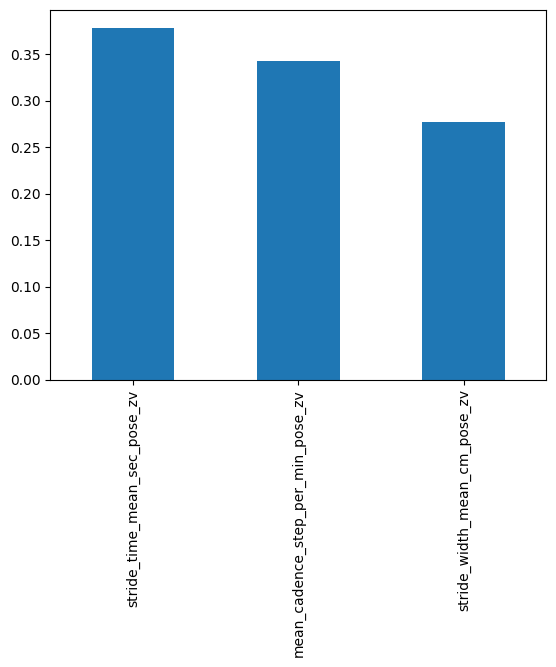

In [29]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances2 = pd.Series(best_rf2.feature_importances_, 
                                index=X2_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances2.plot.bar()

## Model 3: predictors - AGE + fast walk video metrics; outcome: EDSS categories  

In [30]:
# drop rows with missing data 
model3_edss_df = bw_zv_fw_edss_df[['demoEHR_Age','stride_time_mean_sec_pose_zv', 'mean_cadence_step_per_min_pose_zv', 'stride_width_mean_cm_pose_zv',
                                 'edss_severity_cat']]
print(len(model3_edss_df))

model3_edss_df_2 = model3_edss_df.dropna(inplace=False)

print(len(model3_edss_df_2))

192
183


In [31]:
# predictors (X3) 
X3 = model3_edss_df_2[['demoEHR_Age', 'stride_time_mean_sec_pose_zv', 'mean_cadence_step_per_min_pose_zv', 'stride_width_mean_cm_pose_zv']]
print(X3.dtypes)

# outcome = EDSS severity 
y3 = model3_edss_df_2['edss_severity_cat']
print(y3.dtypes)

# split into training and test sets: 80% train, 20% test 
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2)
# train 
print(X3_train.index)
print(len(X3_train))
print(y3_train.index)
print(len(y3_train))

# test 
print(X3_test.index)
print(len(X3_test))
print(y3_test.index)
print(len(y3_test))

demoEHR_Age                          float64
stride_time_mean_sec_pose_zv         float64
mean_cadence_step_per_min_pose_zv    float64
stride_width_mean_cm_pose_zv         float64
dtype: object
category
Index([140, 103,  38, 109, 107, 221,  16,  29,  37, 169,
       ...
        62, 154, 202, 210, 150, 148, 110, 142,   4,  33],
      dtype='int64', length=146)
146
Index([140, 103,  38, 109, 107, 221,  16,  29,  37, 169,
       ...
        62, 154, 202, 210, 150, 148, 110, 142,   4,  33],
      dtype='int64', length=146)
146
Index([ 82, 133, 187,  75, 155,  40, 213,  87, 163,  81, 145, 161, 177,  64,
       115,   5, 193, 211,   6,  95, 143,  91,  98,  27,  61, 220,  34, 190,
       108, 135, 160, 146, 198, 188, 101,  86, 112],
      dtype='int64')
37
Index([ 82, 133, 187,  75, 155,  40, 213,  87, 163,  81, 145, 161, 177,  64,
       115,   5, 193, 211,   6,  95, 143,  91,  98,  27,  61, 220,  34, 190,
       108, 135, 160, 146, 198, 188, 101,  86, 112],
      dtype='int64')
37


In [32]:
# tune hyperparameters with randomized search 
rand_search3 = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=50, 
                                 cv=5)
rand_search3.fit(X3_train, y3_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001451DAAEE00>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001451DAAF370>})

In [33]:
# Print best parameters from grid search 
best_rf3 = rand_search3.best_estimator_
print('Best hyperparameters:',  rand_search3.best_params_)

Best hyperparameters: {'max_depth': 4, 'n_estimators': 150}


In [34]:
# generate predictions from the best model 
y3_pred = best_rf3.predict(X3_test)

In [35]:
# evaluate accuracy, precision, and recall of pred vs true test y vals 
# see documentation for differences in values, think weighted makes most sense 
accuracy = accuracy_score(y3_test, y3_pred)

precision_micro = precision_score(y3_test, y3_pred, average = 'micro')
precision_macro = precision_score(y3_test, y3_pred, average = 'macro')
precision_weighted = precision_score(y3_test, y3_pred, average = 'weighted')

recall_micro = recall_score(y3_test, y3_pred, average = 'micro')
recall_macro = recall_score(y3_test, y3_pred, average = 'macro')
recall_weighted = recall_score(y3_test, y3_pred, average = 'weighted')

print("Accuracy:", accuracy)
print("Precision Micro:", precision_micro)
print("Precision Macro:", precision_macro)
print("Precision Weighted:", precision_weighted)
print("Recall Micro:", recall_micro)
print("Recall Macro:", recall_macro)
print("Recall Weighted:", recall_weighted)

Accuracy: 0.5945945945945946
Precision Micro: 0.5945945945945946
Precision Macro: 0.698529411764706
Precision Weighted: 0.6762718600953895
Recall Micro: 0.5945945945945946
Recall Macro: 0.5777777777777778
Recall Weighted: 0.5945945945945946


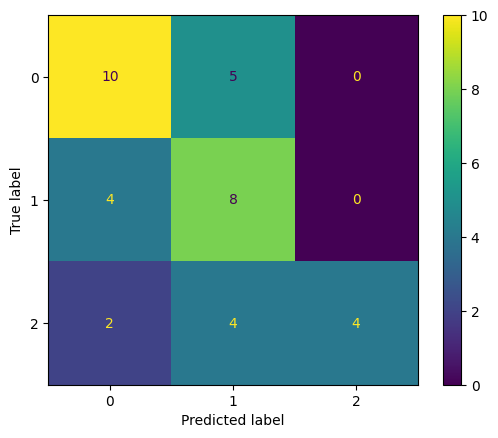

In [36]:
# create confusion matrix 
cm3 = confusion_matrix(y3_test, y3_pred)
ConfusionMatrixDisplay(confusion_matrix=cm3).plot();

<Axes: >

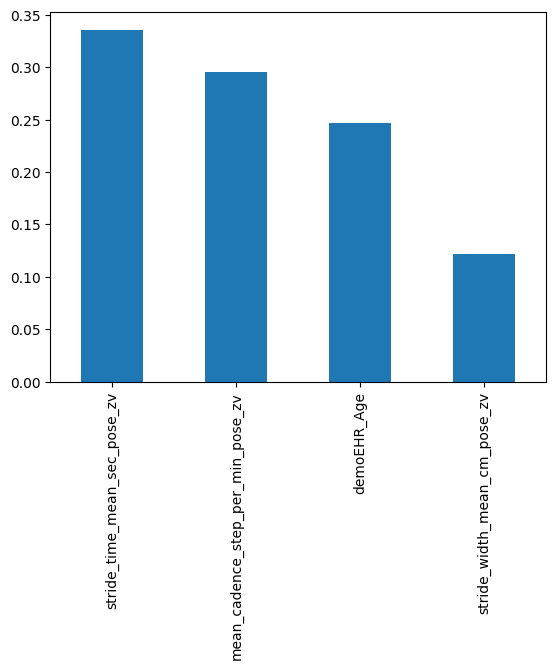

In [37]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances3 = pd.Series(best_rf3.feature_importances_, 
                                index=X3_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances3.plot.bar()

## Model 4: predictors - AGE + fast walk video metrics; outcome: T25FW categories

In [38]:
# drop rows with missing data 
model4_t25fw_df = bw_zv_fw_t25fw_df[['demoEHR_Age', 'stride_time_mean_sec_pose_zv', 'mean_cadence_step_per_min_pose_zv', 'stride_width_mean_cm_pose_zv',
                                     't25fw_group_cat']]
print(len(model4_t25fw_df))

model4_t25fw_df_2 = model4_t25fw_df.dropna(inplace=False)

print(len(model4_t25fw_df_2))

146
141


In [40]:
# predictors (X4) 
X4 = model4_t25fw_df_2[['demoEHR_Age', 'stride_time_mean_sec_pose_zv', 'mean_cadence_step_per_min_pose_zv', 'stride_width_mean_cm_pose_zv']]
print(X4.dtypes)

# outcome = EDSS severity 
y4 = model4_t25fw_df_2['t25fw_group_cat']
print(y4.dtypes)

# split into training and test sets: 80% train, 20% test 
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2)
# train 
print(X4_train.index)
print(len(X4_train))
print(y4_train.index)
print(len(y4_train))

# test 
print(X4_test.index)
print(len(X4_test))
print(y4_test.index)
print(len(y4_test))

demoEHR_Age                          float64
stride_time_mean_sec_pose_zv         float64
mean_cadence_step_per_min_pose_zv    float64
stride_width_mean_cm_pose_zv         float64
dtype: object
category
Index([191, 187,   1, 179,  16,  93, 140,  91, 107,  72,
       ...
       149, 170,  23, 118, 184,  66, 212, 219,  30,  76],
      dtype='int64', length=112)
112
Index([191, 187,   1, 179,  16,  93, 140,  91, 107,  72,
       ...
       149, 170,  23, 118, 184,  66, 212, 219,  30,  76],
      dtype='int64', length=112)
112
Index([ 55, 155,  78, 144,  99,  94, 202,  74, 114,  82,  34, 148, 129,  88,
       132, 177, 112, 142,   0,  26,  11,  31, 193,  77,  27, 127,  86, 135,
       156],
      dtype='int64')
29
Index([ 55, 155,  78, 144,  99,  94, 202,  74, 114,  82,  34, 148, 129,  88,
       132, 177, 112, 142,   0,  26,  11,  31, 193,  77,  27, 127,  86, 135,
       156],
      dtype='int64')
29


In [41]:
# tune hyperparameters with randomized search 
rand_search4 = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=50, 
                                 cv=5)
rand_search4.fit(X4_train, y4_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001451DAAEE00>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001451DAAF370>})

In [43]:
# Print best parameters from grid search 
best_rf4 = rand_search4.best_estimator_
print('Best hyperparameters:',  rand_search4.best_params_)

Best hyperparameters: {'max_depth': 35, 'n_estimators': 68}


In [44]:
# generate predictions from the best model 
y4_pred = best_rf4.predict(X4_test)

In [45]:
# evaluate accuracy, precision, and recall of pred vs true test y vals 
# see documentation for differences in values, think weighted makes most sense 
accuracy = accuracy_score(y4_test, y4_pred)

precision_micro = precision_score(y4_test, y4_pred, average = 'micro')
precision_macro = precision_score(y4_test, y4_pred, average = 'macro')
precision_weighted = precision_score(y4_test, y4_pred, average = 'weighted')

recall_micro = recall_score(y4_test, y4_pred, average = 'micro')
recall_macro = recall_score(y4_test, y4_pred, average = 'macro')
recall_weighted = recall_score(y4_test, y4_pred, average = 'weighted')

print("Accuracy:", accuracy)
print("Precision Micro:", precision_micro)
print("Precision Macro:", precision_macro)
print("Precision Weighted:", precision_weighted)
print("Recall Micro:", recall_micro)
print("Recall Macro:", recall_macro)
print("Recall Weighted:", recall_weighted)

Accuracy: 0.8620689655172413
Precision Micro: 0.8620689655172413
Precision Macro: 0.5555555555555555
Precision Weighted: 0.8362068965517241
Recall Micro: 0.8620689655172413
Recall Macro: 0.6388888888888888
Recall Weighted: 0.8620689655172413


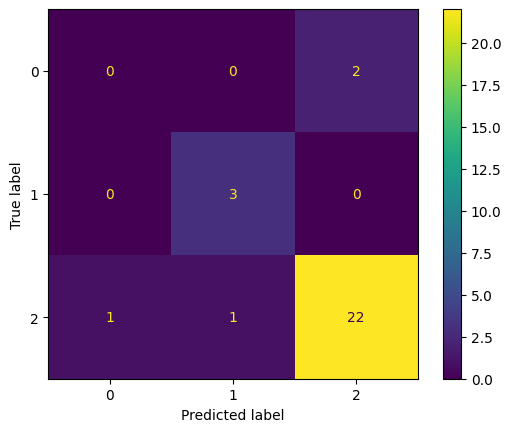

In [46]:
# create confusion matrix 
cm4 = confusion_matrix(y4_test, y4_pred)
ConfusionMatrixDisplay(confusion_matrix=cm4).plot();

<Axes: >

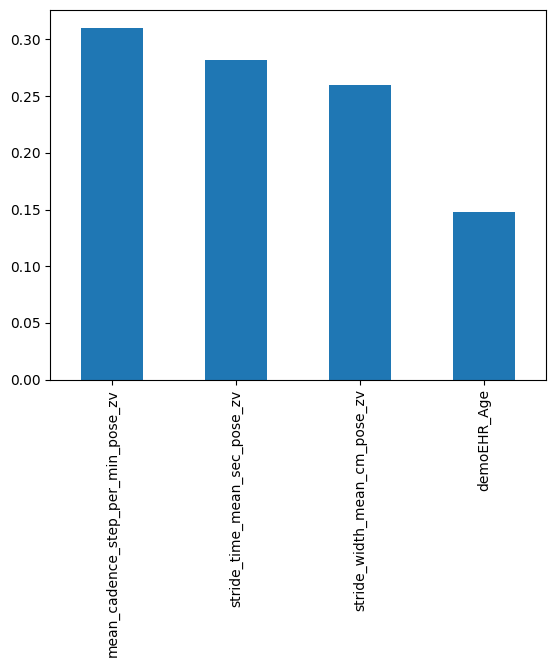

In [47]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances4 = pd.Series(best_rf4.feature_importances_, 
                                index=X4_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances4.plot.bar()